In [1]:
#load library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from tqdm.auto import tqdm
from nltk.corpus import stopwords
tqdm.pandas()

In [2]:
#load dataset
df = pd.read_csv('datasetfinal.csv', encoding = 'utf-8',)
df.head()

,text,labels
0,wood kenapa tidak berani sumpah taruh krnlo cu...,1
1,haha somad somad muka dekil otak tidak malu ak...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [3]:
#pastikan tipe data pada kolom text dan labels
df['text'] = df['text'].astype(str)
df['labels'] = df['labels'].astype(int)

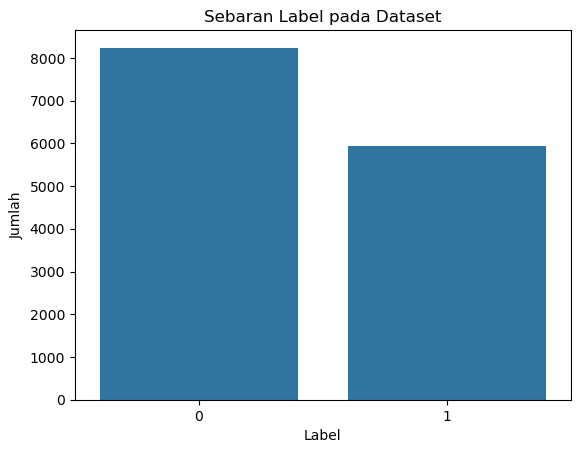

labels
0    8237
1    5934
Name: count, dtype: int64

In [4]:
#lihat sebaran label pada dataset
sns.countplot(x='labels', data=df)
plt.title('Sebaran Label pada Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()
#Cek jumlah data pada setiap label
df['labels'].value_counts()

***PERSIAPKAN WORD-EMBEDDING FASTTEXT***

In [5]:
#load model pre-trained FastText
model_path = 'cc.id.300.bin'

import fasttext
ft_model = fasttext.load_model(model_path)

print(ft_model.get_dimension())  # Output: 300
print(ft_model.get_word_vector("saya")[:10])  # Cek vektor kata

300
[-0.01407608  0.06523435  0.04372576  0.18425423  0.02241408 -0.11397391
 -0.04704365  0.02331188 -0.02006736 -0.05753721]


In [6]:
df = df.dropna(subset=['text'])

In [24]:
#definisikan X dan y
X = df['text'].tolist()
y = df['labels'].values

#tokenisasi teks
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam kamus: {len(word_index)}")

# Mengonversi teks menjadi urutan indeks
sequences = tokenizer.texts_to_sequences(X)

# Padding urutan untuk memastikan panjang yang konsisten
maxlen = max(len(seq) for seq in sequences)
print(f"Panjang maksimum urutan: {maxlen}")

# Padding urutan
X_padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

Jumlah kata unik dalam kamus: 13623
Panjang maksimum urutan: 52


Text(0.5, 1.0, 'Distribusi Panjang Teks')

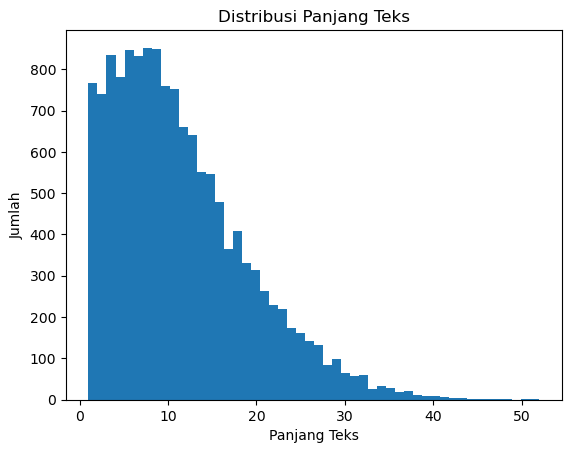

In [25]:
#analisis distribusi panjang kata untuk maxlen
plt.hist([len(seq) for seq in sequences], bins=50)
plt.xlabel('Panjang Teks'); plt.ylabel('Jumlah'); plt.title('Distribusi Panjang Teks')

In [12]:
# Membuat matriks embedding
embedding_dim = ft_model.get_dimension()
num_tokens = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_tokens, embedding_dim))
words_not_found = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    embedding_matrix[i] = ft_model.get_word_vector(word)

print(f"Dimensi matriks embedding: {embedding_matrix.shape}")

Dimensi matriks embedding: (13624, 300)


***DEFINISIKAN ARSITEKTUR MODEL BiLSTM***

In [ ]:
# Definisikan hyperparameter untuk model LSTM
lstm_units = 128                                    # Jumlah unit LSTM
dense_units = 64                                    # Jumlah unit pada lapisan dense
dropout_rate = 0.5                                  # Tingkat dropout untuk regularisasi
learning_rate = 0.001                               # Tingkat pembelajaran awal untuk optimizer Adam
epochs = 10                                         # Jumlah epoch pelatihan
batch_size = 64                                     # Ukuran batch untuk pelatihan

In [26]:
# Bangun model LSTM
def build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    
    model.add(Embedding(input_dim=num_tokens,
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=maxlen,
                        trainable=False))
    
    #Lapisan BiLSTM untuk menangkap konteks dari kedua arah
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan Dense dengan aktivasi ReLU
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan output dengan aktivasi sigmoid untuk klasifikasi biner
    model.add(Dense(1, activation='sigmoid'))

    return model

# Inisialisasi model
model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
# Bangun model secara eksplisit dengan menentukan input_shape
model.build(input_shape=(None, maxlen))
model.summary()

c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 52, 300)        │     4,087,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,543,009 (17.33 MB)

 Trainable params: 455,809 (1.74 MB)

 Non-trainable params: 4,087,200 (15.59 MB)

In [27]:
# Compile model
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),]

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
print("Model telah dicompile.")

Model telah dicompile.


***PELATIHAN DAN EVALUASI MODEL***

In [28]:
#Definisikan X dan y untuk model pelatihan dan evaluasi
X_cv = X_padded
y_cv = y

print(f"Total data instances for Cross-Validation: {len(X_cv)}")
print(f"Overall data distribution for Cross-Validation: {Counter(y_cv)}")

Total data instances for Cross-Validation: 14171
Overall data distribution for Cross-Validation: Counter({0: 8237, 1: 5934})


In [ ]:
#Definisikan Fungsi untuk Melatih dan Mengevaluasi Model pada Satu Fold
def train_and_evaluate_single_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_idx, technique_name):
    print(f"\n===== Training and Evaluating {technique_name} - Fold {fold_idx+1} =====")
    
    # Rebuild model to ensure fresh weights for each fold
    model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
    model.build(input_shape=(None, maxlen)) # Pastikan model dibangun
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Metrik untuk kompilasi model di dalam fungsi ini
    METRICS_FOLD = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'), # [8, 19]
        tf.keras.metrics.Recall(name='recall'),       # [8, 19]
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS_FOLD)
    
    # Definisikan EarlyStopping callback
    # Monitor 'val_F1ScoreCustom' dan mode='max' karena F1-Score harus dimaksimalkan [2, 5]
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True, verbose=1) # [2, 5]
    
    # Pastikan tipe data numerik yang benar untuk TensorFlow
    X_train_fold = X_train_fold.astype(np.float32)
    y_train_fold = y_train_fold.astype(np.int32)
    X_val_fold = X_val_fold.astype(np.float32)
    y_val_fold = y_val_fold.astype(np.int32)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold), # Gunakan validation_data langsung [5]
                        callbacks=[early_stopping], # Tambahkan callback EarlyStopping di sini
                        verbose=1)
    
    # Make predictions on the validation fold
    y_pred_prob = model.predict(X_val_fold)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics for this fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, zero_division=0)
    recall = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    
    print(f"Fold {fold_idx+1} Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'y_true': y_val_fold, 'y_pred': y_pred}


--- Starting 5-Fold Cross-Validation for Random Oversampling ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (Random Oversampling): Counter({1: 6589, 0: 6589})

===== Training and Evaluating Random Oversampling - Fold 1 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.6528 - loss: 0.6171 - precision: 0.6590 - recall: 0.6287 - val_accuracy: 0.7379 - val_loss: 0.5125 - val_precision: 0.6832 - val_recall: 0.6976
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - accuracy: 0.7734 - loss: 0.4841 - precision: 0.7639 - recall: 0.7907 - val_accuracy: 0.7587 - val_loss: 0.4919 - val_precision: 0.6762 - val_recall: 0.8130
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.7864 - loss: 0.4580 - precision: 0.7713 - recall: 0.8099 - val_accuracy: 0.7661 - val_loss: 0.4775 - val_precision: 0.6853 - val_recall: 0.8163
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.7999 - loss: 0.4356 - precision: 0.7870 - recall: 0.8271 - val_accuracy: 0.7665 - val_loss: 0.4834 - val_precision: 0.6761 - val_recall: 0.8492
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.8060 - loss: 0.4190 - precision: 0.7877 - recall: 0.8407 - val_accuracy: 0.7852

 20%|██        | 1/5 [06:07<24:30, 367.54s/it]

Fold 1 Metrics: Accuracy=0.7721, Precision=0.6872, Recall=0.8366, F1-Score=0.7546
Waktu untuk Random Oversampling: 367.54 detik
Fold 2 - Resampled training set distribution (Random Oversampling): Counter({1: 6590, 0: 6590})

===== Training and Evaluating Random Oversampling - Fold 2 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6364 - loss: 0.6256 - precision: 0.6467 - recall: 0.5736 - val_accuracy: 0.7699 - val_loss: 0.4909 - val_precision: 0.7565 - val_recall: 0.6647
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - accuracy: 0.7656 - loss: 0.4848 - precision: 0.7618 - recall: 0.7857 - val_accuracy: 0.7682 - val_loss: 0.4876 - val_precision: 0.6882 - val_recall: 0.8163
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.7774 - loss: 0.4627 - precision: 0.7660 - recall: 0.8095 - val_accuracy: 0.7752 - val_loss: 0.4702 - val_precision: 0.7068 - val_recall: 0.7919
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.7964 - loss: 0.4391 - precision: 0.7868 - recall: 0.8188 - val_accuracy: 0.7830 - val_loss: 0.4688 - val_precision: 0.7115 - val_recall: 0.8104
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - accuracy: 0.8051 - loss: 0.4241 - precision: 0.7884 - recall: 0.8319 - val_accuracy: 0.7865

 40%|████      | 2/5 [10:23<15:05, 301.72s/it]

Fold 2 Metrics: Accuracy=0.7830, Precision=0.7115, Recall=0.8104, F1-Score=0.7578
Waktu untuk Random Oversampling: 623.19 detik
Fold 3 - Resampled training set distribution (Random Oversampling): Counter({1: 6590, 0: 6590})

===== Training and Evaluating Random Oversampling - Fold 3 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6391 - loss: 0.6226 - precision: 0.6306 - recall: 0.6607 - val_accuracy: 0.7519 - val_loss: 0.4961 - val_precision: 0.6930 - val_recall: 0.7321
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.7643 - loss: 0.4904 - precision: 0.7564 - recall: 0.7805 - val_accuracy: 0.7646 - val_loss: 0.4901 - val_precision: 0.6920 - val_recall: 0.7894
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - accuracy: 0.7890 - loss: 0.4562 - precision: 0.7832 - recall: 0.7998 - val_accuracy: 0.7650 - val_loss: 0.4878 - val_precision: 0.6945 - val_recall: 0.7835
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.8003 - loss: 0.4315 - precision: 0.7970 - recall: 0.8122 - val_accuracy: 0.7668 - val_loss: 0.4772 - val_precision: 0.7426 - val_recall: 0.6782
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.8103 - loss: 0.4055 - precision: 0.8053 - recall: 0.8208 - val_accuracy: 0.7784 - val_loss

 60%|██████    | 3/5 [15:11<09:51, 295.55s/it]

Fold 3 Metrics: Accuracy=0.7784, Precision=0.7135, Recall=0.7869, F1-Score=0.7484
Waktu untuk Random Oversampling: 911.40 detik
Fold 4 - Resampled training set distribution (Random Oversampling): Counter({1: 6590, 0: 6590})

===== Training and Evaluating Random Oversampling - Fold 4 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.6420 - loss: 0.6272 - precision: 0.6579 - recall: 0.5343 - val_accuracy: 0.7657 - val_loss: 0.4883 - val_precision: 0.7149 - val_recall: 0.7329
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.7640 - loss: 0.4954 - precision: 0.7529 - recall: 0.7761 - val_accuracy: 0.7805 - val_loss: 0.4678 - val_precision: 0.7287 - val_recall: 0.7582
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.7830 - loss: 0.4632 - precision: 0.7799 - recall: 0.7902 - val_accuracy: 0.7872 - val_loss: 0.4512 - val_precision: 0.7500 - val_recall: 0.7380
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.7957 - loss: 0.4349 - precision: 0.7874 - recall: 0.8097 - val_accuracy: 0.7900 - val_loss: 0.4513 - val_precision: 0.7539 - val_recall: 0.7405
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.7943 - loss: 0.4332 - precision: 0.7904 - recall: 0.8035 - val_accuracy: 0.7858

 80%|████████  | 4/5 [20:42<05:09, 309.61s/it]

Fold 4 Metrics: Accuracy=0.7936, Precision=0.7963, Recall=0.6816, F1-Score=0.7345
Waktu untuk Random Oversampling: 1242.55 detik
Fold 5 - Resampled training set distribution (Random Oversampling): Counter({1: 6589, 0: 6589})

===== Training and Evaluating Random Oversampling - Fold 5 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.6447 - loss: 0.6199 - precision: 0.6582 - recall: 0.5567 - val_accuracy: 0.7534 - val_loss: 0.4948 - val_precision: 0.6603 - val_recall: 0.8457
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.7630 - loss: 0.5009 - precision: 0.7553 - recall: 0.7760 - val_accuracy: 0.7664 - val_loss: 0.4711 - val_precision: 0.6817 - val_recall: 0.8288
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.7846 - loss: 0.4596 - precision: 0.7758 - recall: 0.7943 - val_accuracy: 0.7618 - val_loss: 0.4811 - val_precision: 0.6716 - val_recall: 0.8432
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.8019 - loss: 0.4394 - precision: 0.7953 - recall: 0.8068 - val_accuracy: 0.7855 - val_loss: 0.4406 - val_precision: 0.7474 - val_recall: 0.7361
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.7993 - loss: 0.4333 - precision: 0.7945 - recall: 0.8100 - val_accuracy: 0.7791 - val_loss

100%|██████████| 5/5 [26:13<00:00, 314.68s/it]


Fold 5 Metrics: Accuracy=0.7975, Precision=0.7402, Recall=0.7951, F1-Score=0.7667
Waktu untuk Random Oversampling: 1573.40 detik

Average Metrics for Random Oversampling across 5 folds:
{'accuracy': 0.7849137520085532, 'precision': 0.7297411382565768, 'recall': 0.7821053259666624, 'f1_score': 0.7523710089409604, 'technique': 'Random Oversampling'}

--- Starting 5-Fold Cross-Validation for SMOTE ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (SMOTE): Counter({1: 6589, 0: 6589})

===== Training and Evaluating SMOTE - Fold 1 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.6033 - loss: 0.6472 - precision: 0.5908 - recall: 0.7152 - val_accuracy: 0.7460 - val_loss: 0.5219 - val_precision: 0.6919 - val_recall: 0.7094
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.7290 - loss: 0.5420 - precision: 0.7228 - recall: 0.7280 - val_accuracy: 0.7422 - val_loss: 0.5098 - val_precision: 0.6492 - val_recall: 0.8357
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.7475 - loss: 0.5133 - precision: 0.7386 - recall: 0.7751 - val_accuracy: 0.7711 - val_loss: 0.4755 - val_precision: 0.6961 - val_recall: 0.8045
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.7737 - loss: 0.4785 - precision: 0.7685 - recall: 0.7833 - val_accuracy: 0.7616 - val_loss: 0.5020 - val_precision: 0.6754 - val_recall: 0.8290
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.7838 - loss: 0.4577 - precision: 0.7776 - recall: 0.7940 - val_accuracy: 0.7192

 20%|██        | 1/5 [03:44<14:58, 224.62s/it]

Fold 1 Metrics: Accuracy=0.7711, Precision=0.6961, Recall=0.8045, F1-Score=0.7464
Waktu untuk SMOTE: 224.62 detik
Fold 2 - Resampled training set distribution (SMOTE): Counter({1: 6590, 0: 6590})

===== Training and Evaluating SMOTE - Fold 2 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.6019 - loss: 0.6483 - precision: 0.6034 - recall: 0.5827 - val_accuracy: 0.7459 - val_loss: 0.5235 - val_precision: 0.6713 - val_recall: 0.7709
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.7333 - loss: 0.5395 - precision: 0.7276 - recall: 0.7474 - val_accuracy: 0.7795 - val_loss: 0.4895 - val_precision: 0.7461 - val_recall: 0.7178
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 168ms/step - accuracy: 0.7534 - loss: 0.5098 - precision: 0.7507 - recall: 0.7480 - val_accuracy: 0.7728 - val_loss: 0.4836 - val_precision: 0.7216 - val_recall: 0.7447
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.7682 - loss: 0.4823 - precision: 0.7623 - recall: 0.7702 - val_accuracy: 0.7534 - val_loss: 0.4996 - val_precision: 0.6644 - val_recall: 0.8307
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.7804 - loss: 0.4651 - precision: 0.7740 - recall: 0.7940 - val_accuracy: 0.7632 - val_loss

 40%|████      | 2/5 [07:25<11:08, 222.67s/it]

Fold 2 Metrics: Accuracy=0.7728, Precision=0.7216, Recall=0.7447, F1-Score=0.7330
Waktu untuk SMOTE: 445.93 detik
Fold 3 - Resampled training set distribution (SMOTE): Counter({1: 6590, 0: 6590})

===== Training and Evaluating SMOTE - Fold 3 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.6109 - loss: 0.6400 - precision: 0.6000 - recall: 0.7076 - val_accuracy: 0.7378 - val_loss: 0.5258 - val_precision: 0.6462 - val_recall: 0.8265
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.7301 - loss: 0.5379 - precision: 0.7315 - recall: 0.7312 - val_accuracy: 0.7565 - val_loss: 0.4933 - val_precision: 0.6861 - val_recall: 0.7717
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.7524 - loss: 0.5004 - precision: 0.7519 - recall: 0.7466 - val_accuracy: 0.7703 - val_loss: 0.4770 - val_precision: 0.6923 - val_recall: 0.8130
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.7773 - loss: 0.4697 - precision: 0.7704 - recall: 0.7852 - val_accuracy: 0.7491 - val_loss: 0.5226 - val_precision: 0.6467 - val_recall: 0.8837
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.7829 - loss: 0.4613 - precision: 0.7808 - recall: 0.7927 - val_accuracy: 0.7664 - val_loss

 60%|██████    | 3/5 [13:24<09:29, 284.85s/it]

Fold 3 Metrics: Accuracy=0.7858, Precision=0.7224, Recall=0.7936, F1-Score=0.7563
Waktu untuk SMOTE: 804.76 detik
Fold 4 - Resampled training set distribution (SMOTE): Counter({1: 6590, 0: 6590})

===== Training and Evaluating SMOTE - Fold 4 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step - accuracy: 0.6060 - loss: 0.6482 - precision: 0.6040 - recall: 0.5809 - val_accuracy: 0.7301 - val_loss: 0.5728 - val_precision: 0.6643 - val_recall: 0.7186
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 190ms/step - accuracy: 0.7182 - loss: 0.5597 - precision: 0.7205 - recall: 0.7129 - val_accuracy: 0.7668 - val_loss: 0.4794 - val_precision: 0.6868 - val_recall: 0.8147
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.7494 - loss: 0.5104 - precision: 0.7433 - recall: 0.7625 - val_accuracy: 0.7615 - val_loss: 0.4919 - val_precision: 0.6704 - val_recall: 0.8467
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step - accuracy: 0.7605 - loss: 0.4882 - precision: 0.7505 - recall: 0.7720 - val_accuracy: 0.7576 - val_loss: 0.4845 - val_precision: 0.6621 - val_recall: 0.8602
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.7812 - loss: 0.4594 - precision: 0.7765 - recall: 0.7907 - val_accuracy: 0.7724

 80%|████████  | 4/5 [20:18<05:35, 335.66s/it]

Fold 4 Metrics: Accuracy=0.7890, Precision=0.7335, Recall=0.7793, F1-Score=0.7557
Waktu untuk SMOTE: 1218.32 detik
Fold 5 - Resampled training set distribution (SMOTE): Counter({1: 6589, 0: 6589})

===== Training and Evaluating SMOTE - Fold 5 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.6088 - loss: 0.6456 - precision: 0.6128 - recall: 0.6212 - val_accuracy: 0.7590 - val_loss: 0.5130 - val_precision: 0.7228 - val_recall: 0.6880
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.7272 - loss: 0.5450 - precision: 0.7300 - recall: 0.7269 - val_accuracy: 0.7710 - val_loss: 0.4917 - val_precision: 0.7461 - val_recall: 0.6863
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.7369 - loss: 0.5272 - precision: 0.7411 - recall: 0.7290 - val_accuracy: 0.7802 - val_loss: 0.4775 - val_precision: 0.6945 - val_recall: 0.8474
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.7578 - loss: 0.5011 - precision: 0.7638 - recall: 0.7508 - val_accuracy: 0.7897 - val_loss: 0.4436 - val_precision: 0.7364 - val_recall: 0.7749
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.7686 - loss: 0.4727 - precision: 0.7641 - recall: 0.7695 - val_accuracy: 0.7925

100%|██████████| 5/5 [27:08<00:00, 325.61s/it]


Fold 5 Metrics: Accuracy=0.7982, Precision=0.7277, Recall=0.8272, F1-Score=0.7743
Waktu untuk SMOTE: 1628.06 detik

Average Metrics for SMOTE across 5 folds:
{'accuracy': 0.7833612508230245, 'precision': 0.7202758087742283, 'recall': 0.7898613563747797, 'f1_score': 0.7531397220585336, 'technique': 'SMOTE'}

--- Starting 5-Fold Cross-Validation for ADASYN ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (ADASYN): Counter({0: 6589, 1: 5852})

===== Training and Evaluating ADASYN - Fold 1 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.6197 - loss: 0.6412 - precision: 0.6338 - recall: 0.3836 - val_accuracy: 0.7439 - val_loss: 0.5197 - val_precision: 0.6929 - val_recall: 0.6976
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.7344 - loss: 0.5364 - precision: 0.7143 - recall: 0.7356 - val_accuracy: 0.7573 - val_loss: 0.4952 - val_precision: 0.6817 - val_recall: 0.7885
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - accuracy: 0.7451 - loss: 0.5150 - precision: 0.7391 - recall: 0.7141 - val_accuracy: 0.7534 - val_loss: 0.4976 - val_precision: 0.6642 - val_recall: 0.8315
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - accuracy: 0.7721 - loss: 0.4798 - precision: 0.7589 - recall: 0.7709 - val_accuracy: 0.7566 - val_loss: 0.4885 - val_precision: 0.6632 - val_recall: 0.8509
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.7867 - loss: 0.4585 - precision: 0.7708 - recall: 0.7754 - val_accuracy: 0.7810 - val_loss

 20%|██        | 1/5 [05:06<20:26, 306.65s/it]

Fold 1 Metrics: Accuracy=0.7810, Precision=0.7084, Recall=0.8104, F1-Score=0.7560
Waktu untuk ADASYN: 306.65 detik
Fold 2 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 5839})

===== Training and Evaluating ADASYN - Fold 2 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.6266 - loss: 0.6395 - precision: 0.6319 - recall: 0.4915 - val_accuracy: 0.7721 - val_loss: 0.5112 - val_precision: 0.7099 - val_recall: 0.7709
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - accuracy: 0.7398 - loss: 0.5289 - precision: 0.7231 - recall: 0.7298 - val_accuracy: 0.7819 - val_loss: 0.4779 - val_precision: 0.7285 - val_recall: 0.7641
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - accuracy: 0.7542 - loss: 0.5073 - precision: 0.7428 - recall: 0.7296 - val_accuracy: 0.7459 - val_loss: 0.5342 - val_precision: 0.6486 - val_recall: 0.8585
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.7781 - loss: 0.4664 - precision: 0.7618 - recall: 0.7642 - val_accuracy: 0.7841 - val_loss: 0.4671 - val_precision: 0.7255 - val_recall: 0.7793
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.7922 - loss: 0.4440 - precision: 0.7831 - recall: 0.7748 - val_accuracy: 0.7883 - val_loss

 40%|████      | 2/5 [10:26<15:43, 314.64s/it]

Fold 2 Metrics: Accuracy=0.7883, Precision=0.7448, Recall=0.7523, F1-Score=0.7485
Waktu untuk ADASYN: 626.88 detik
Fold 3 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 5895})

===== Training and Evaluating ADASYN - Fold 3 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 50s 224ms/step - accuracy: 0.6032 - loss: 0.6432 - precision: 0.6071 - recall: 0.4279 - val_accuracy: 0.7290 - val_loss: 0.5428 - val_precision: 0.6280 - val_recall: 0.8660
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.7443 - loss: 0.5270 - precision: 0.7257 - recall: 0.7292 - val_accuracy: 0.7565 - val_loss: 0.5115 - val_precision: 0.6764 - val_recall: 0.8029
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.7604 - loss: 0.4969 - precision: 0.7510 - recall: 0.7290 - val_accuracy: 0.7685 - val_loss: 0.4879 - val_precision: 0.6825 - val_recall: 0.8366
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.7841 - loss: 0.4656 - precision: 0.7720 - recall: 0.7693 - val_accuracy: 0.7781 - val_loss: 0.4716 - val_precision: 0.7036 - val_recall: 0.8121
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.7825 - loss: 0.4585 - precision: 0.7636 - recall: 0.7823 - val_accuracy: 0.7932

 60%|██████    | 3/5 [16:26<11:10, 335.33s/it]

Fold 3 Metrics: Accuracy=0.7950, Precision=0.7612, Recall=0.7439, F1-Score=0.7524
Waktu untuk ADASYN: 986.84 detik
Fold 4 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 5883})

===== Training and Evaluating ADASYN - Fold 4 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.6168 - loss: 0.6466 - precision: 0.6053 - recall: 0.5762 - val_accuracy: 0.7678 - val_loss: 0.4890 - val_precision: 0.7149 - val_recall: 0.7414
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - accuracy: 0.7404 - loss: 0.5241 - precision: 0.7273 - recall: 0.7121 - val_accuracy: 0.7752 - val_loss: 0.4887 - val_precision: 0.7142 - val_recall: 0.7725
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - accuracy: 0.7635 - loss: 0.5018 - precision: 0.7515 - recall: 0.7479 - val_accuracy: 0.7738 - val_loss: 0.4797 - val_precision: 0.6904 - val_recall: 0.8340
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.7720 - loss: 0.4773 - precision: 0.7598 - recall: 0.7560 - val_accuracy: 0.7929 - val_loss: 0.4463 - val_precision: 0.8112 - val_recall: 0.6588
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - accuracy: 0.7852 - loss: 0.4547 - precision: 0.7719 - recall: 0.7736 - val_accuracy: 0.7879 - val_loss

 80%|████████  | 4/5 [21:00<05:11, 311.07s/it]

Fold 4 Metrics: Accuracy=0.7929, Precision=0.8112, Recall=0.6588, F1-Score=0.7271
Waktu untuk ADASYN: 1260.73 detik
Fold 5 - Resampled training set distribution (ADASYN): Counter({0: 6589, 1: 5875})

===== Training and Evaluating ADASYN - Fold 5 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.6129 - loss: 0.6484 - precision: 0.6117 - recall: 0.4667 - val_accuracy: 0.7445 - val_loss: 0.5198 - val_precision: 0.6502 - val_recall: 0.8432
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.7330 - loss: 0.5443 - precision: 0.7211 - recall: 0.6949 - val_accuracy: 0.7749 - val_loss: 0.5026 - val_precision: 0.6874 - val_recall: 0.8474
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.7517 - loss: 0.5085 - precision: 0.7458 - recall: 0.7279 - val_accuracy: 0.7664 - val_loss: 0.4780 - val_precision: 0.6799 - val_recall: 0.8347
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 204ms/step - accuracy: 0.7689 - loss: 0.4845 - precision: 0.7665 - recall: 0.7428 - val_accuracy: 0.7837 - val_loss: 0.4516 - val_precision: 0.7090 - val_recall: 0.8196
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.7755 - loss: 0.4703 - precision: 0.7638 - recall: 0.7424 - val_accuracy: 0.7932 - val_loss

100%|██████████| 5/5 [27:58<00:00, 335.61s/it]

Fold 5 Metrics: Accuracy=0.7957, Precision=0.7679, Recall=0.7336, F1-Score=0.7503
Waktu untuk ADASYN: 1678.06 detik

Average Metrics for ADASYN across 5 folds:
{'accuracy': 0.7905588601001445, 'precision': 0.7586930281406854, 'recall': 0.739803463888585, 'f1_score': 0.7468804550650463, 'technique': 'ADASYN'}

Visualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:


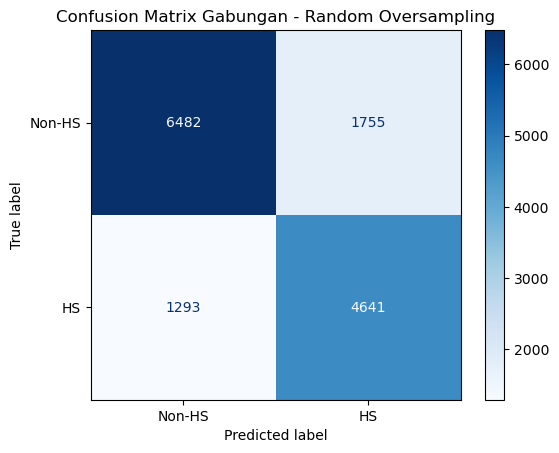

<Figure size 640x480 with 0 Axes>

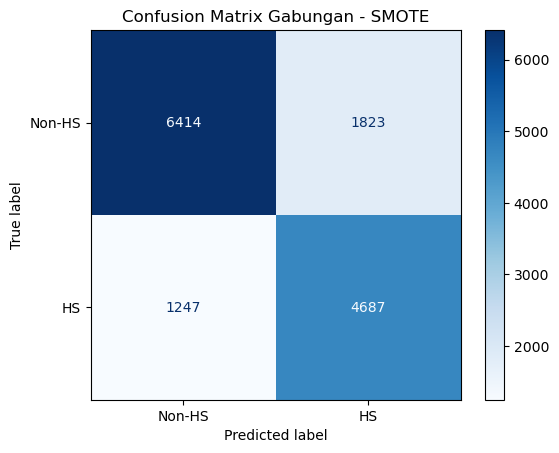

<Figure size 640x480 with 0 Axes>

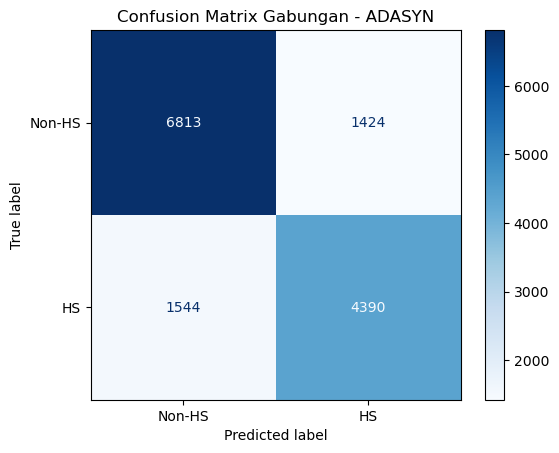


Perbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):
   accuracy  precision    recall  f1_score            technique
0  0.784914   0.729741  0.782105  0.752371  Random Oversampling
1  0.783361   0.720276  0.789861  0.753140                SMOTE
2  0.790559   0.758693  0.739803  0.746880               ADASYN


<Figure size 640x480 with 0 Axes>

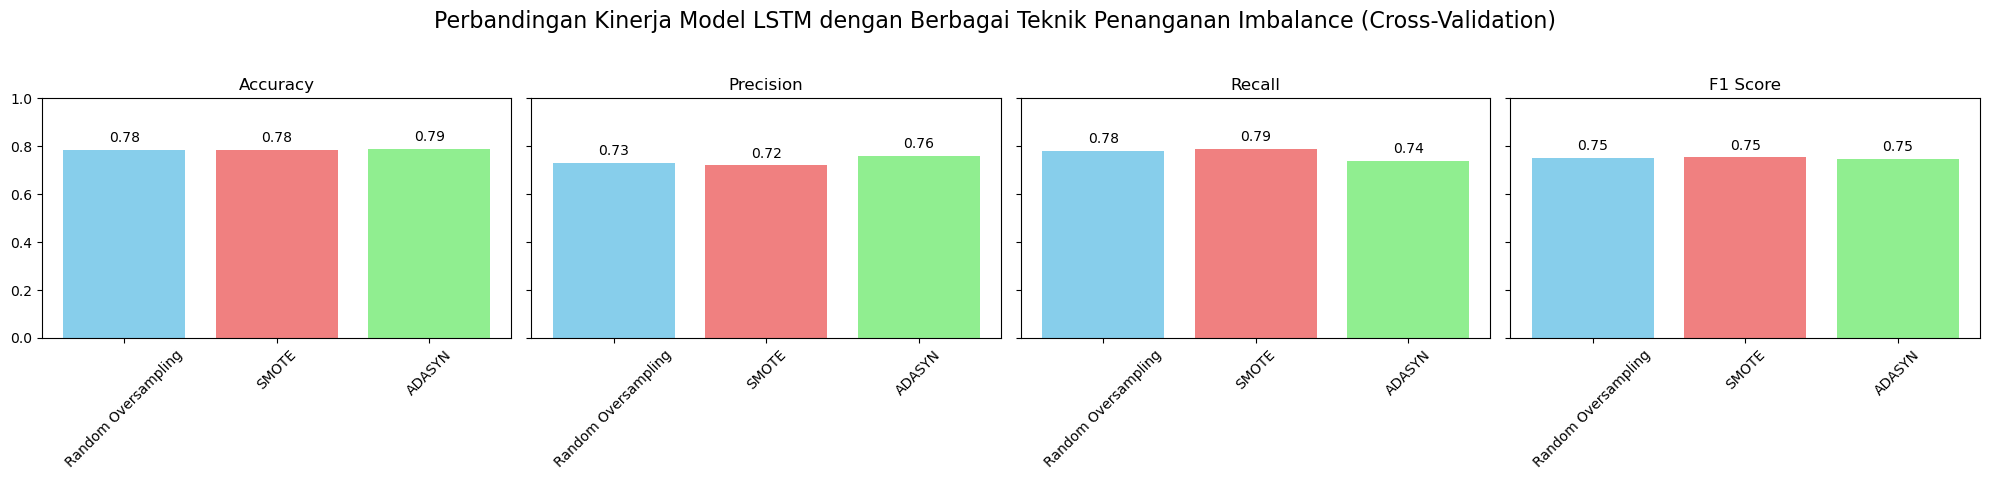

In [30]:
#Implementasi K-Fold Cross-Validation untuk Setiap Teknik Oversampling
n_splits = 5 # Jumlah folds untuk cross-validation [1, 2]
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # [2]

from tqdm import tqdm
import time

all_results = {}
confusion_matrices = {}

# List teknik penanganan imbalance dan inisialisasi objeknya
oversampling_methods = {
    "Random Oversampling": RandomOverSampler(random_state=42), # [23, 6]
    "SMOTE": SMOTE(random_state=42), # [6, 24]
    "ADASYN": ADASYN(random_state=42), # [22, 23]
}

for tech_name, oversampler in oversampling_methods.items():
    fold_metrics = []
    all_y_true = []
    all_y_pred = []

    print(f"\n--- Starting {n_splits}-Fold Cross-Validation for {tech_name} ---")
    start_time = time.time()
    
    # Loop melalui setiap fold Stratified K-Fold
    # skf.split akan membagi X_data_for_cv dan y_data_for_cv (seluruh dataset)
    for fold_idx, (train_idx, val_idx) in tqdm(enumerate(skf.split(X_cv, y_cv)), total=n_splits):
        # Ambil data pelatihan dan validasi untuk fold saat ini (data asli)
        X_train_fold_orig, X_val_fold_orig = X_cv[train_idx], X_cv[val_idx]
        y_train_fold_orig, y_val_fold_orig = y_cv[train_idx], y_cv[val_idx]
        
        X_train_fold_resampled, y_train_fold_resampled = oversampler.fit_resample(X_train_fold_orig, y_train_fold_orig)
        print(f"Fold {fold_idx+1} - Resampled training set distribution ({tech_name}): {Counter(y_train_fold_resampled)}")

        # Latih dan evaluasi model pada fold ini
        metrics = train_and_evaluate_single_fold(
            X_train_fold_resampled, y_train_fold_resampled,
            X_val_fold_orig, y_val_fold_orig, # Evaluasi pada data validasi asli (tidak di-oversample)
            fold_idx,
            tech_name, # Teruskan nama teknik ke fungsi evaluasi
        )

        fold_metrics.append(metrics)
        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])

        print(f"Waktu untuk {tech_name}: {time.time() - start_time:.2f} detik")
    
    # Confusion matrix gabungan untuk teknik ini
    cm = confusion_matrix(all_y_true, all_y_pred)
    confusion_matrices[tech_name] = cm

    # Rata-rata metrik
    metric_df = pd.DataFrame([{k: v for k, v in d.items() if k in ['accuracy', 'precision', 'recall', 'f1_score']} for d in fold_metrics])
    avg_metrics = metric_df.mean().to_dict()
    avg_metrics['technique'] = tech_name
    all_results[tech_name] = avg_metrics

    print(f"\nAverage Metrics for {tech_name} across {n_splits} folds:")
    print(avg_metrics)

# Visualisasi confusion matrix per teknik
print("\nVisualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:")
for tech_name, cm in confusion_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-HS', 'HS'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix Gabungan - {tech_name}')
    plt.show()
    plt.savefig(f"confusion_matrix_{tech_name}.png", dpi=300, bbox_inches='tight')

# Konversi hasil evaluasi ke DataFrame
results_df = pd.DataFrame(list(all_results.values()))
print("\nPerbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):")
print(results_df)

# Plot perbandingan metrik
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 5), sharey=True)
fig.suptitle('Perbandingan Kinerja Model LSTM dengan Berbagai Teknik Penanganan Imbalance (Cross-Validation)', fontsize=16)

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(results_df['technique'], results_df[metric], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    for index, row in results_df.iterrows():
        axes[i].text(index, row[metric] + 0.02, f"{row[metric]:.2f}", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()